In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Libraries Needed

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing import image
from PIL import Image, ImageDraw, ImageFont
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras import layers, optimizers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from keras.callbacks import ReduceLROnPlateau


from tensorflow.keras.applications import ResNet50, InceptionV3, VGG16, EfficientNetB0,MobileNet 
 
from sklearn.utils import class_weight
  

# Data Preparation

In [3]:
dataset_training_path = '/kaggle/input/tomato-quality-data/data/Training_set'
dataset_testing_path = '/kaggle/input/tomato-quality-data/data/Testing_set'

# Initialize ImageDataGenerator for training and testing
datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load the training images using the ImageDataGenerator
train_generator = datagen.flow_from_directory(
    dataset_training_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  
)

# Load the testing images using the ImageDataGenerator
test_generator = datagen.flow_from_directory(
    dataset_testing_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  
)

print("Training classes:", train_generator.class_indices)
print("Testing classes:", test_generator.class_indices)


Found 5122 images belonging to 6 classes.
Found 1275 images belonging to 6 classes.
Training classes: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Testing classes: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}


#  Building Models

## CNN Model

In [4]:
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.2),
    layers.Dense(6, activation='softmax')
])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## CNN Fitting

In [5]:
cnn_history = cnn_model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,callbacks=[early_stopping,reduce_lr]
 )

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727600296.034523      83 service.cc:145] XLA service 0x7cb814011120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727600296.034576      83 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727600296.034580      83 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/161 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.2188 - loss: 19.0797

I0000 00:00:1727600304.285110      83 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


161/161 ━━━━━━━━━━━━━━━━━━━━ 55s 269ms/step - accuracy: 0.3986 - loss: 8.8920 - val_accuracy: 0.4345 - val_loss: 4.2207 - learning_rate: 0.0010
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.4699 - loss: 1.5073 - val_accuracy: 0.4549 - val_loss: 1.4870 - learning_rate: 0.0010
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.4846 - loss: 1.5368 - val_accuracy: 0.4698 - val_loss: 1.4454 - learning_rate: 0.0010
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.4731 - loss: 1.4507 - val_accuracy: 0.4714 - val_loss: 1.4181 - learning_rate: 0.0010
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.4826 - loss: 1.3973 - val_accuracy: 0.4667 - val_loss: 1.4743 - learning_rate: 0.0010
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - accuracy: 0.4763 - loss: 1.3784 - val_accuracy: 0.4871 - val_loss: 1.4407 - learning_rate: 0.0010
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.4794 - loss: 1.353

## Evaluation

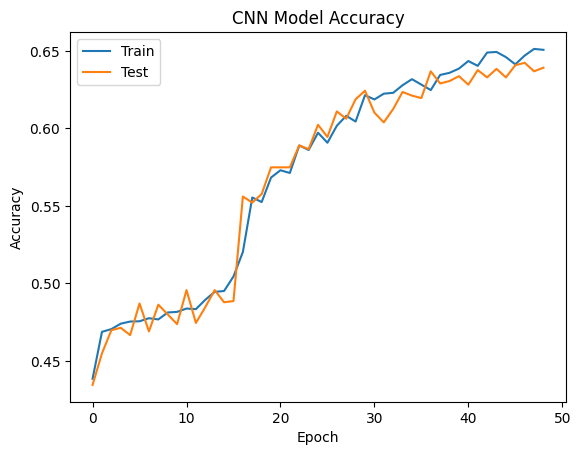

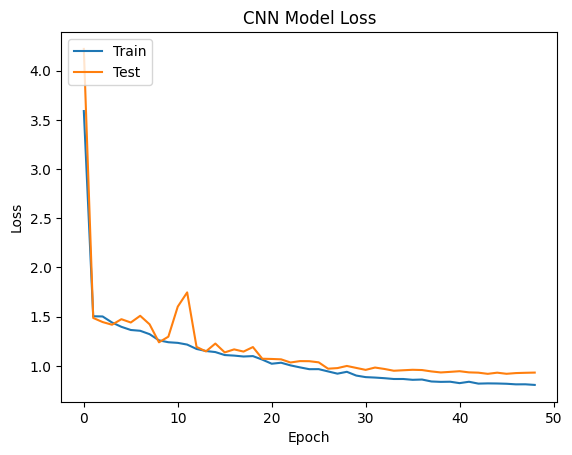

In [6]:
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [7]:
cnn_train_evaluation = cnn_model.evaluate(train_generator)
print("CNN Training Accuracy:", cnn_train_evaluation[1])
cnn_test_eval = cnn_model.evaluate(test_generator)
print("CNN Test Accuracy:", cnn_test_eval[1])

161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.7158 - loss: 0.7052
CNN Training Accuracy: 0.7046075463294983
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.6279 - loss: 0.9255
CNN Test Accuracy: 0.6384313702583313


## MobileNet Model

In [8]:
mobilenet_base = MobileNet(weights=None, include_top=False, input_shape=(224, 224, 3))

weights_path = '/kaggle/input/mobilenet/mobilenet_1_0_224_tf_no_top.h5'   
mobilenet_base.load_weights(weights_path)

for layer in mobilenet_base.layers[-15:]:
    layer.trainable = True

x = mobilenet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

mobilenet_model = Model(inputs=mobilenet_base.input, outputs=predictions)
mobilenet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

## MobileNet Fitting

In [9]:
mobile_history = mobilenet_model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,callbacks=[early_stopping,reduce_lr])

Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 61s 204ms/step - accuracy: 0.5456 - loss: 1.1783 - val_accuracy: 0.5129 - val_loss: 2.0073 - learning_rate: 0.0010
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.6763 - loss: 0.7787 - val_accuracy: 0.6039 - val_loss: 0.9994 - learning_rate: 0.0010
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.6988 - loss: 0.7114 - val_accuracy: 0.6220 - val_loss: 1.1621 - learning_rate: 0.0010
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.7508 - loss: 0.5904 - val_accuracy: 0.6447 - val_loss: 1.0332 - learning_rate: 0.0010
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.7910 - loss: 0.5219 - val_accuracy: 0.7192 - val_loss: 0.6775 - learning_rate: 0.0010
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.8432 - loss: 0.4039 - val_accuracy: 0.6478 - val_loss: 0.8363 - learning_rate: 0.0010
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.8

## Evaluation

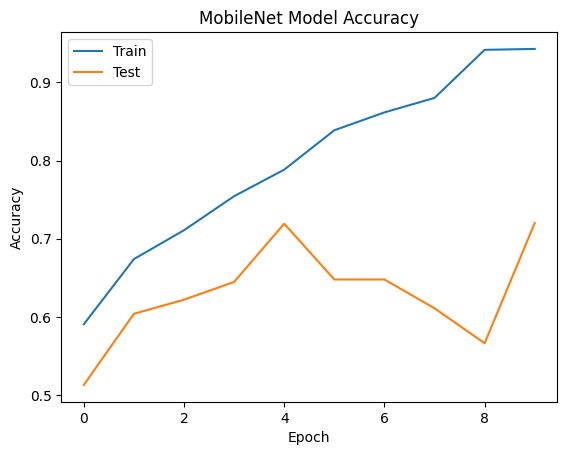

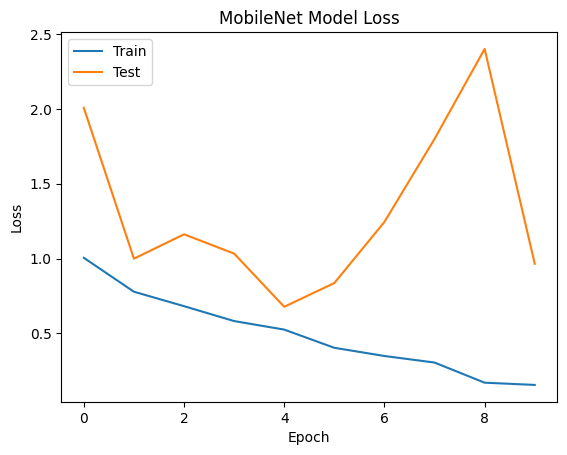

In [10]:
plt.plot(mobile_history.history['accuracy'])
plt.plot(mobile_history.history['val_accuracy'])
plt.title('MobileNet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(mobile_history.history['loss'])
plt.plot(mobile_history.history['val_loss'])
plt.title('MobileNet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
mobilenet_test_evaluation = mobilenet_model.evaluate(test_generator)
mobilenet_train_evaluation = mobilenet_model.evaluate(train_generator)
print("MobileNet Train Accuracy:", mobilenet_train_evaluation[1])
print("MobileNet Test Accuracy:", mobilenet_test_evaluation[1])

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.6885 - loss: 0.7479
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.8536 - loss: 0.3723
MobileNet Train Accuracy: 0.8533775806427002
MobileNet Test Accuracy: 0.7192156910896301


## ResNet

In [12]:
resnet_base = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))  

weights_path = '/kaggle/input/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop (1).h5'  
resnet_base.load_weights(weights_path)

for layer in resnet_base.layers[-10:]:   
    layer.trainable = True

x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

resnet_model = Model(inputs=resnet_base.input, outputs=predictions)
resnet_model.compile(optimizer= Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

## ResNet Fitting

In [13]:
resnet_history = resnet_model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,callbacks=[early_stopping,reduce_lr])

Epoch 1/50


I0000 00:00:1727601421.146569      84 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_26', 20 bytes spill stores, 20 bytes spill loads



103/161 ━━━━━━━━━━━━━━━━━━━━ 29s 504ms/step - accuracy: 0.4726 - loss: 1.4642

I0000 00:00:1727601472.781944      82 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_39', 8 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 20 bytes spill stores, 20 bytes spill loads



161/161 ━━━━━━━━━━━━━━━━━━━━ 142s 498ms/step - accuracy: 0.4918 - loss: 1.3910 - val_accuracy: 0.4635 - val_loss: 7.8598 - learning_rate: 0.0010
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 53s 326ms/step - accuracy: 0.5691 - loss: 1.0667 - val_accuracy: 0.4635 - val_loss: 3.4593 - learning_rate: 0.0010
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 52s 320ms/step - accuracy: 0.6222 - loss: 0.9529 - val_accuracy: 0.1686 - val_loss: 1.8127 - learning_rate: 0.0010
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 52s 318ms/step - accuracy: 0.6305 - loss: 0.9062 - val_accuracy: 0.4635 - val_loss: 2.0704 - learning_rate: 0.0010
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 83s 327ms/step - accuracy: 0.6081 - loss: 0.9877 - val_accuracy: 0.4957 - val_loss: 1.3606 - learning_rate: 0.0010
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 52s 318ms/step - accuracy: 0.6789 - loss: 0.7971 - val_accuracy: 0.5537 - val_loss: 1.1682 - learning_rate: 0.0010
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 52s 319ms/step - accuracy: 0.7150 - loss

## Evaluation

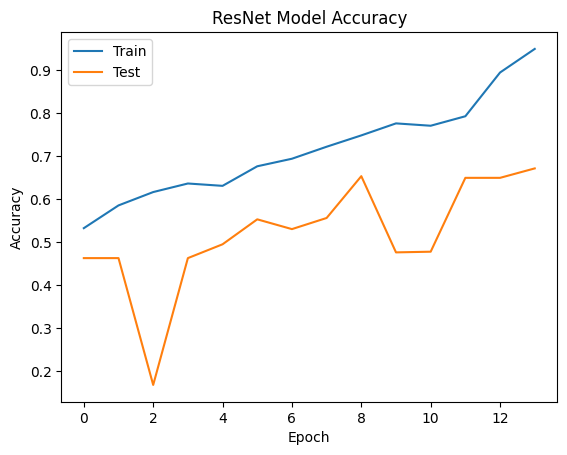

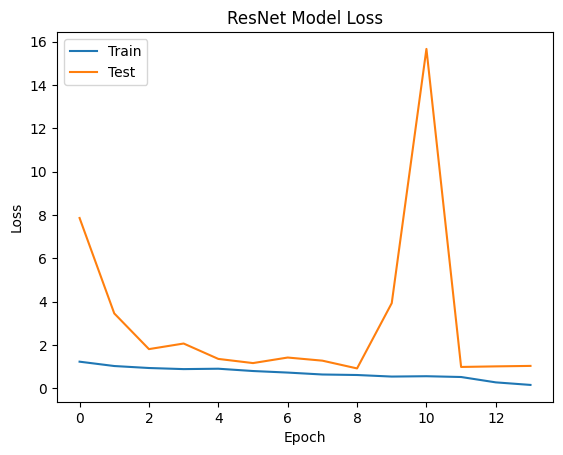

In [14]:
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('ResNet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('ResNet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
resnet_test_evaluation = resnet_model.evaluate(test_generator)
resnet_train_evaluation = resnet_model.evaluate(train_generator)
print("ResNet Train Accuracy:", resnet_train_evaluation[1])
print("ResNet Test Accuracy:", resnet_test_evaluation[1])

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.6391 - loss: 0.9383
161/161 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.7510 - loss: 0.6104
ResNet Train Accuracy: 0.7510737776756287
ResNet Test Accuracy: 0.6541176438331604


## VGG16 Model

In [16]:
vgg16_base = VGG16(weights= None, include_top=False, input_shape=(224, 224, 3))

weights_path = '/kaggle/input/weights-vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'  
vgg16_base.load_weights(weights_path)


for layer in vgg16_base.layers[-10:]:
    layer.trainable = False

x = vgg16_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

vgg16_model = Model(inputs=vgg16_base.input, outputs=predictions)
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## VGG16 Fitting

In [17]:
vgg_history = vgg16_model.fit(train_generator, validation_data=test_generator, epochs=50, 
                             callbacks=[early_stopping,reduce_lr]) 

Epoch 1/50
  4/161 ━━━━━━━━━━━━━━━━━━━━ 7:53 3s/step - accuracy: 0.4625 - loss: 1.5477   

I0000 00:00:1727602396.718820      85 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_3', 164 bytes spill stores, 164 bytes spill loads



161/161 ━━━━━━━━━━━━━━━━━━━━ 134s 548ms/step - accuracy: 0.4612 - loss: 1.5148 - val_accuracy: 0.4635 - val_loss: 1.3868 - learning_rate: 0.0010
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 64s 396ms/step - accuracy: 0.4741 - loss: 1.3618 - val_accuracy: 0.4659 - val_loss: 1.3425 - learning_rate: 0.0010
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 64s 395ms/step - accuracy: 0.4953 - loss: 1.2884 - val_accuracy: 0.5122 - val_loss: 1.2779 - learning_rate: 0.0010
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 64s 397ms/step - accuracy: 0.5157 - loss: 1.2376 - val_accuracy: 0.4580 - val_loss: 1.2996 - learning_rate: 0.0010
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 64s 397ms/step - accuracy: 0.5430 - loss: 1.1712 - val_accuracy: 0.5584 - val_loss: 1.1144 - learning_rate: 0.0010
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 64s 397ms/step - accuracy: 0.5600 - loss: 1.0967 - val_accuracy: 0.5545 - val_loss: 1.1058 - learning_rate: 0.0010
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 82s 400ms/step - accuracy: 0.5553 - loss

## Evalaution

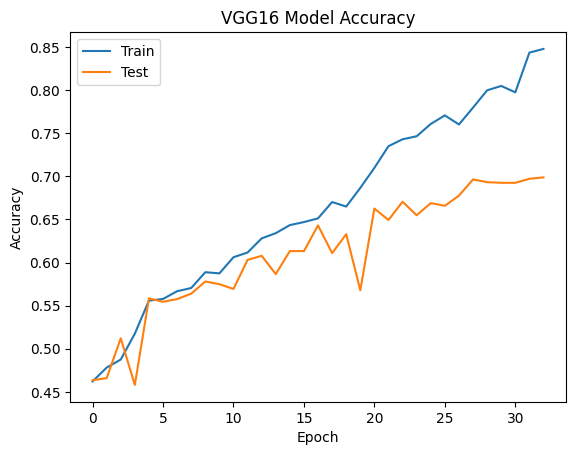

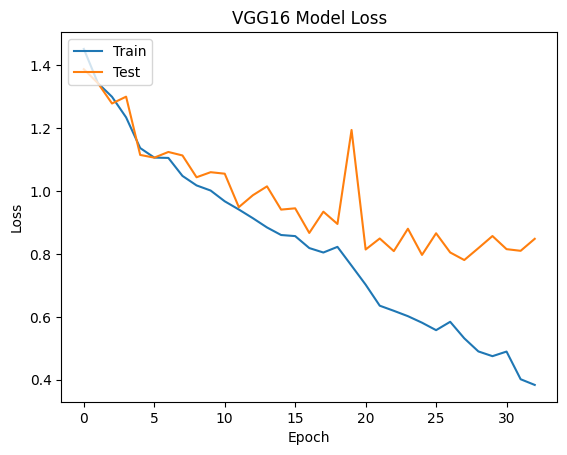

In [18]:
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('VGG16 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('VGG16 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
vgg_test_evaluation = vgg16_model.evaluate(test_generator)
vgg_train_evaluation = vgg16_model.evaluate(train_generator)
print("VGG16 Train Accuracy:", vgg_train_evaluation[1])
print("VGG16 Test Accuracy:", vgg_test_evaluation[1])

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.6927 - loss: 0.7788
161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.8109 - loss: 0.4647
VGG16 Train Accuracy: 0.8164779543876648
VGG16 Test Accuracy: 0.6964705586433411


## Inception Model

In [20]:
inception_base = InceptionV3(weights=None, include_top=False, input_shape=(224, 224, 3))

weights_path = '/kaggle/input/inception/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'  
inception_base.load_weights(weights_path)

for layer in inception_base.layers[-40:]:
    layer.trainable = False

x = inception_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

inception_model = Model(inputs=inception_base.input, outputs=predictions)
inception_model.compile(optimizer= Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

## Inception Fitting

In [21]:
inception_history = inception_model.fit(train_generator, validation_data=test_generator,
                                        epochs=50 ,callbacks=[early_stopping,reduce_lr])

Epoch 1/50
111/161 ━━━━━━━━━━━━━━━━━━━━ 23s 469ms/step - accuracy: 0.4703 - loss: 1.3517

I0000 00:00:1727604750.996408      84 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion', 56 bytes spill stores, 56 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_1', 24 bytes spill stores, 24 bytes spill loads



161/161 ━━━━━━━━━━━━━━━━━━━━ 151s 493ms/step - accuracy: 0.4878 - loss: 1.3063 - val_accuracy: 0.2471 - val_loss: 2.9370 - learning_rate: 0.0010
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 40s 244ms/step - accuracy: 0.5927 - loss: 1.0273 - val_accuracy: 0.5169 - val_loss: 3.6159 - learning_rate: 0.0010
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 38s 236ms/step - accuracy: 0.6285 - loss: 0.9033 - val_accuracy: 0.4761 - val_loss: 4.7271 - learning_rate: 0.0010
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 39s 240ms/step - accuracy: 0.6345 - loss: 0.8548 - val_accuracy: 0.4016 - val_loss: 1.6897 - learning_rate: 0.0010
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 39s 238ms/step - accuracy: 0.6830 - loss: 0.7456 - val_accuracy: 0.4847 - val_loss: 11.3315 - learning_rate: 0.0010
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 39s 239ms/step - accuracy: 0.6984 - loss: 0.7586 - val_accuracy: 0.5059 - val_loss: 3.3513 - learning_rate: 0.0010
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 39s 240ms/step - accuracy: 0.7347 - los

## Evaluation

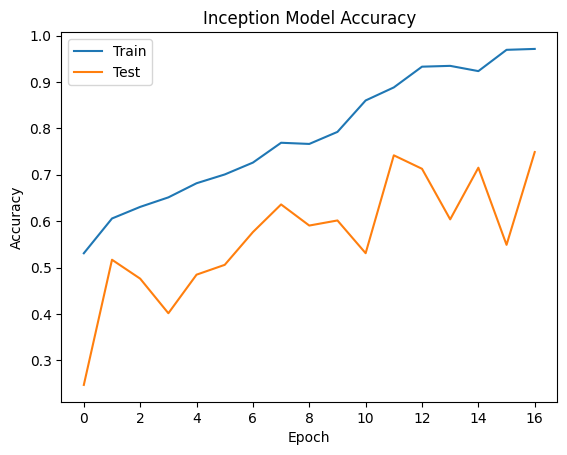

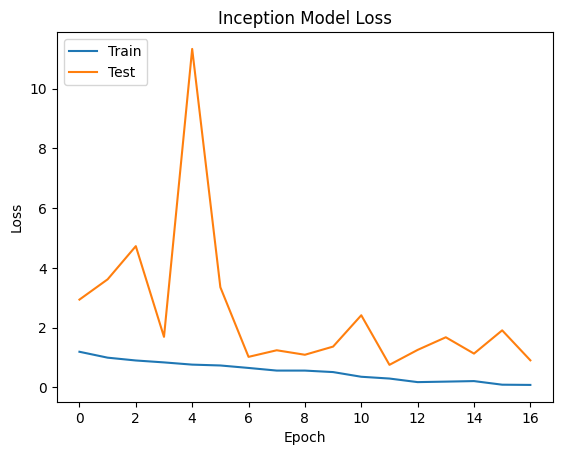

In [22]:
plt.plot(inception_history.history['accuracy'])
plt.plot(inception_history.history['val_accuracy'])
plt.title('Inception Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(inception_history.history['loss'])
plt.plot(inception_history.history['val_loss'])
plt.title('Inception Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
inception_test_evaluation = inception_model.evaluate(test_generator)
inception_train_evaluation = inception_model.evaluate(train_generator)
print("Inception Train Accuracy:", inception_train_evaluation[1])
print("Inception Test Accuracy:", inception_test_evaluation[1])

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.7631 - loss: 0.6752
161/161 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.9502 - loss: 0.1691
Inception Train Accuracy: 0.9494338035583496
Inception Test Accuracy: 0.7419607639312744


## EfficientNet Model

In [24]:
efficientnet_base = EfficientNetB0(weights= None, include_top=False, input_shape=(224, 224, 3))

weights_path = '/kaggle/input/efficientnet/efficientnetb0_notop.h5'  
efficientnet_base.load_weights(weights_path)

for layer in efficientnet_base.layers[-20:]:
    layer.trainable = False

x = efficientnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

efficientnet_model = Model(inputs=efficientnet_base.input, outputs=predictions)
efficientnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## EfficientNet Fitting

In [25]:
eff_history = efficientnet_model.fit(train_generator, validation_data=test_generator,
                                     epochs=50, callbacks=[early_stopping,reduce_lr])

Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 162s 501ms/step - accuracy: 0.5511 - loss: 1.1442 - val_accuracy: 0.0596 - val_loss: 2.2928 - learning_rate: 0.0010
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 25s 149ms/step - accuracy: 0.6889 - loss: 0.7520 - val_accuracy: 0.1192 - val_loss: 2.4089 - learning_rate: 0.0010
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - accuracy: 0.7499 - loss: 0.6006 - val_accuracy: 0.2329 - val_loss: 1.6571 - learning_rate: 0.0010
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.7987 - loss: 0.4859 - val_accuracy: 0.0965 - val_loss: 2.2992 - learning_rate: 0.0010
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 42s 146ms/step - accuracy: 0.8249 - loss: 0.4376 - val_accuracy: 0.4110 - val_loss: 1.4894 - learning_rate: 0.0010
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 147ms/step - accuracy: 0.8561 - loss: 0.3690 - val_accuracy: 0.5106 - val_loss: 1.3115 - learning_rate: 0.0010
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - accuracy: 0.

## Evaluation

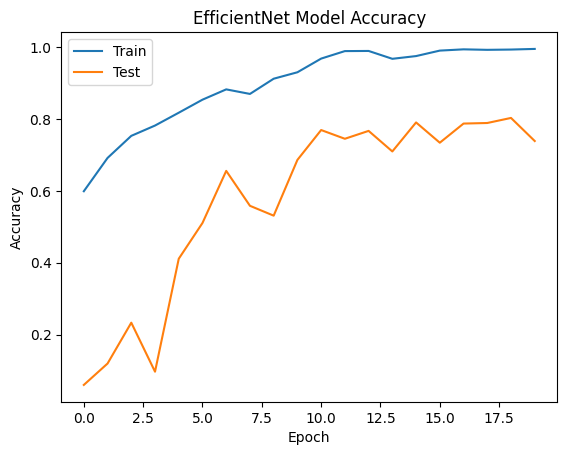

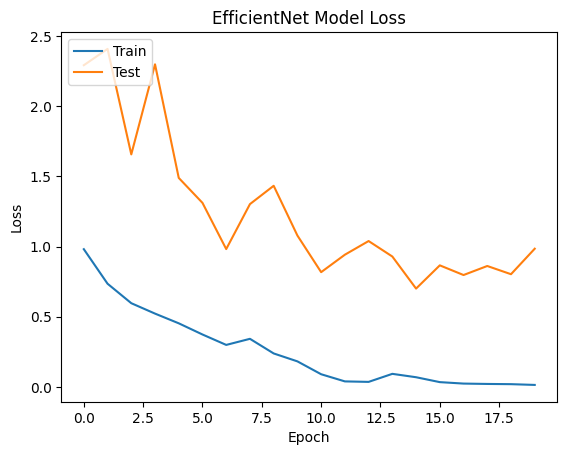

In [26]:
plt.plot(eff_history.history['accuracy'])
plt.plot(eff_history.history['val_accuracy'])
plt.title('EfficientNet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(eff_history.history['loss'])
plt.plot(eff_history.history['val_loss'])
plt.title('EfficientNet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [27]:
eff_test_evaluation = efficientnet_model.evaluate(test_generator)
eff_train_evaluation = efficientnet_model.evaluate(train_generator)
print("EfficientNet Train Accuracy:", eff_train_evaluation[1])
print("EfficientNet Test Accuracy:", eff_test_evaluation[1])

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.7912 - loss: 0.6688
161/161 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.9958 - loss: 0.0211
EfficientNet Train Accuracy: 0.995314359664917
EfficientNet Test Accuracy: 0.7905882596969604


# Models Evaluation and Comparison

In [28]:
cnn_eval = cnn_model.evaluate(test_generator)
print("CNN Test Accuracy:", cnn_eval[1])

resnet_eval = resnet_model.evaluate(test_generator)
print("ResNet Test Accuracy:", resnet_eval[1])

vgg16_eval = vgg16_model.evaluate(test_generator)
print("VGG16 Test Accuracy:", vgg16_eval[1])

inception_eval = inception_model.evaluate(test_generator)
print("InceptionV3 Test Accuracy:", inception_eval[1])

efficientnet_eval = efficientnet_model.evaluate(test_generator)
print("EfficientNet Test Accuracy:", efficientnet_eval[1])

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.6429 - loss: 0.9643
CNN Test Accuracy: 0.6384313702583313
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.6425 - loss: 0.9755
ResNet Test Accuracy: 0.6541176438331604
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.6980 - loss: 0.7881
VGG16 Test Accuracy: 0.6964705586433411
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.7431 - loss: 0.7636
InceptionV3 Test Accuracy: 0.7419607639312744
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.7890 - loss: 0.6663
EfficientNet Test Accuracy: 0.7905882596969604


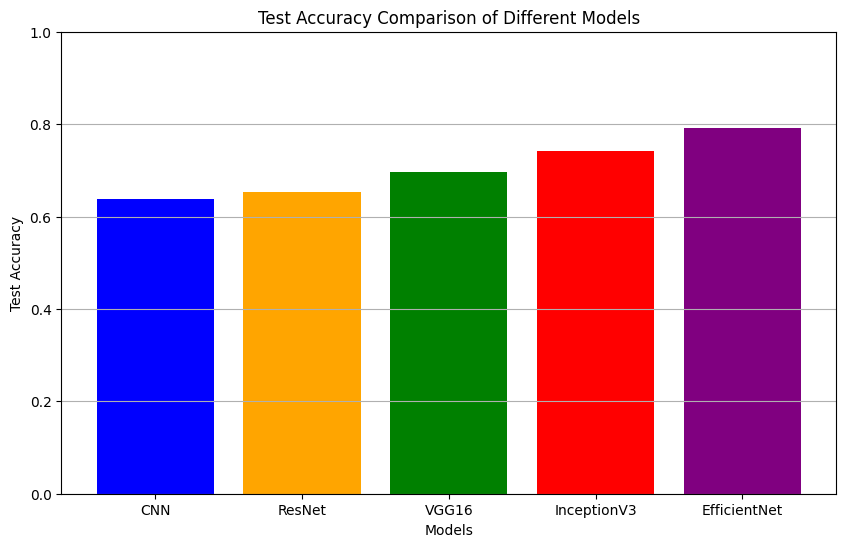

In [29]:
model_names = ['CNN', 'ResNet', 'VGG16', 'InceptionV3', 'EfficientNet']
accuracies = [
    cnn_eval[1], 
    resnet_eval[1], 
    vgg16_eval[1], 
    inception_eval[1], 
    efficientnet_eval[1]
]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.ylim(0, 1)   
plt.title('Test Accuracy Comparison of Different Models')
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.grid(axis='y')

plt.show()